In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from utils.grad import grad, batch_grad

In [2]:
device = torch.device('cpu')

# Function

In [3]:
f = lambda x: (-x**2 * torch.log(x)).squeeze()
dfdx = lambda x: -(2 * x * torch.log(x) + x)

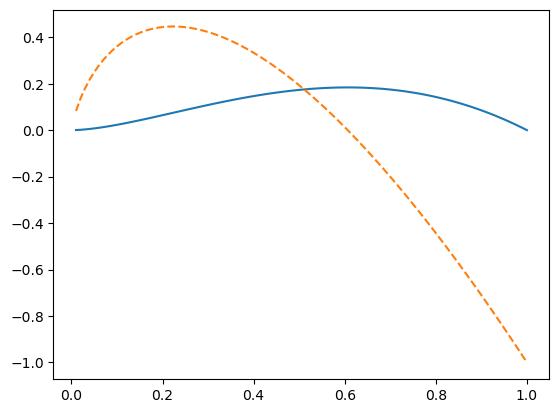

In [4]:
x = torch.linspace(0, 1, 100)
plt.plot(x, f(x))
plt.plot(x, batch_grad(f)(x), linestyle='dashed')

# Model

In [5]:
class MLP(nn.Module):

    def __init__(self):
        super().__init__()

        h = 16
        self.mlp = nn.Sequential(
            nn.Linear(1, h), 
            nn.LayerNorm(h), 
            nn.SiLU(), 
            nn.Dropout(0.5), 
            nn.Linear(h, 1)
        )
    
    def forward(self, x):
        return self.mlp(x).squeeze()

# Sampler

In [6]:
class HMC():
    '''
    Hamiltonian Monte Carlo sampler
    '''
    def __init__(self, device=torch.device('cpu')):
        self.device=device
        self.potential = lambda J : 0
        self.kinetic = lambda v: (v ** 2) / 2
    
    @torch.no_grad
    def solve(self, x, v, dt=0.001, runtime=32):

        v -= 0.5 * dt * grad(self.potential)(x)
        x += dt * v
        
        for t in range(runtime):
            v -= dt * grad(self.potential)(x)
            x += dt * v
    
        v -= 0.5 * dt * grad(self.potential)(x)
        
        return x, v

    def step(self, x_0):

        v_0 = torch.randn_like(x_0, device=self.device).detach()
        H_0 = self.potential(x_0) + self.kinetic(v_0)

        x, v = self.solve(x_0, v_0)
        H = self.potential(x) + self.kinetic(v)

        p_accept = torch.exp(H_0 - H)
        if torch.all(p_accept > torch.rand_like(p_accept, device=self.device)):
            return x

        return x_0

# Training

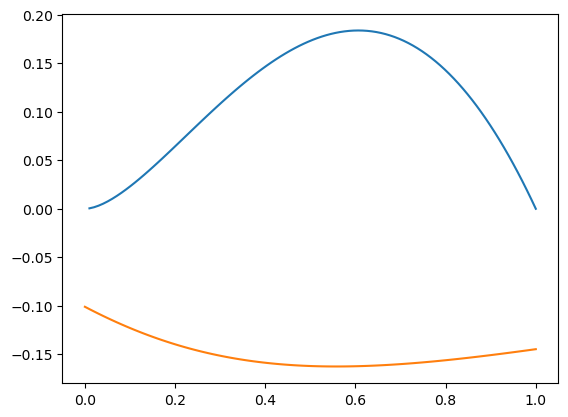

In [7]:
g = MLP()
g.to(device);
optimizer = torch.optim.Adam(g.parameters())

sampler = HMC(device);

g.eval()
x = torch.linspace(0, 1, 100).unsqueeze(1)
plt.plot(x.squeeze(), f(x).squeeze())
plt.plot(x.squeeze(), g(x).squeeze().detach())

In [8]:
epochs = 512
betas = 5/(1 + torch.exp(-16 * (torch.arange(epochs) - (epochs / 2))/epochs)).detach()

In [9]:
losses = []
xs = []

Text(0, 0.5, '$x$')

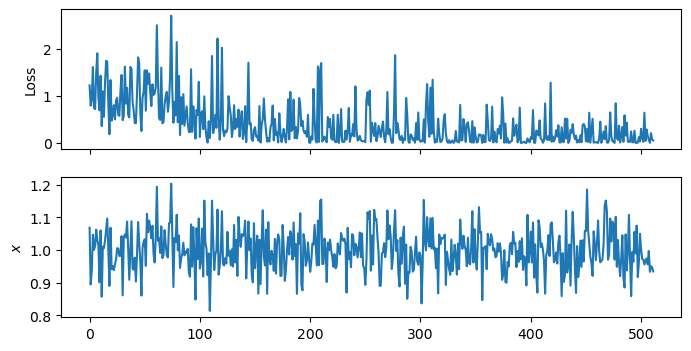

In [10]:
g.train()
for epoch in range(512):
    optimizer.zero_grad()

    sampler.potential = lambda x : -betas[epoch] * grad(g)(x).squeeze().norm()

    x = torch.ones(1, device=device).detach()
    for i in range(4):
        x = torch.clamp(sampler.step(x), min=0).detach()

    dg = grad(g)(x)
    df = (dfdx(x)).detach()

    loss = (dg - df) ** 2
    loss.backward()
    optimizer.step()

    losses.append(float(loss))
    xs.append(float(x))

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(8, 4), sharex=True)
ax0.plot(losses)
ax0.set_ylabel('Loss')
ax1.plot(xs)
ax1.set_ylabel(r'$x$')

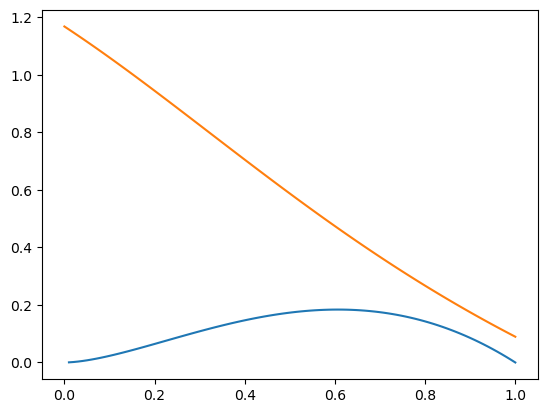

In [11]:
g.eval()
x = torch.linspace(0, 1, 100).unsqueeze(1)
plt.plot(x.squeeze(), f(x).squeeze())
plt.plot(x.squeeze(), g(x).squeeze().detach())